This script is running on cpu.
전체 데이터셋 크기: 900
훈련셋 크기: 576 (64.0%)
검증셋 크기: 144 (16.0%)
테스트셋 크기: 180 (20.0%)
train_input: torch.Size([576, 2])
train_label: torch.Size([576, 1])
val_input: torch.Size([144, 2])
val_label: torch.Size([144, 1])
test_input: torch.Size([180, 2])
test_label: torch.Size([180, 1])


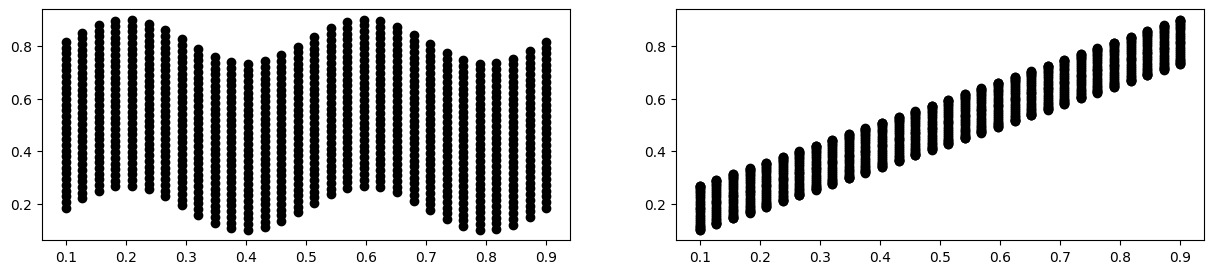

In [2]:
import numpy as np
import torch
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from kan import KAN
from kan.custom import MultKAN
from kan.custom_utils import remove_outliers_iqr, evaluate_model_performance, plot_activation_functions
import datetime
import matplotlib.pyplot as plt
save_tag = 'toy' + datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
save_dir = os.path.join(os.getcwd(), 'custom_figures')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"This script is running on {device}.")

x1_grid = np.linspace(-np.pi, np.pi, 30)
x2_grid = np.linspace(-0.5, 1, 30)
x3_grid = np.linspace(-1, 1, 10)

x1, x2= np.meshgrid(x1_grid, x2_grid)
X = np.stack((x1.flatten(), x2.flatten()), axis=1)
# y = 10 * np.abs(x1) + 5*x2**2
y = np.sin(2*x1) + 5 * x2

y = y.flatten().reshape(-1, 1)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)  # 0.2 × 0.8 = 0.16 (전체의 16%)

print(f"전체 데이터셋 크기: {len(X)}")
print(f"훈련셋 크기: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"검증셋 크기: {len(X_val)} ({len(X_val)/len(X)*100:.1f}%)")
print(f"테스트셋 크기: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")

scaler_X = MinMaxScaler(feature_range=(0.1, 0.9))
scaler_y = MinMaxScaler(feature_range=(0.1, 0.9))
X_train_norm = scaler_X.fit_transform(X_train) # 훈련 데이터로 스케일러 학습 및 변환 (fit_transform)
y_train_norm = scaler_y.fit_transform(y_train)

X_val_norm = scaler_X.transform(X_val)
y_val_norm = scaler_y.transform(y_val)
X_test_norm = scaler_X.transform(X_test)
y_test_norm = scaler_y.transform(y_test)

X_train_tensor = torch.tensor(X_train_norm, dtype=torch.float32, device=device)
X_val_tensor = torch.tensor(X_val_norm, dtype=torch.float32, device=device)
X_test_tensor = torch.tensor(X_test_norm, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train_norm, dtype=torch.float32, device=device)
y_val_tensor = torch.tensor(y_val_norm, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test_norm, dtype=torch.float32, device=device)

dataset = {'train_input': X_train_tensor,'train_label': y_train_tensor,
            'val_input': X_val_tensor, 'val_label': y_val_tensor,
            'test_input': X_test_tensor,'test_label': y_test_tensor }

for key, value in dataset.items():
    print(f"{key}: {value.shape}")

X_norm = scaler_X.transform(X)
y_norm = scaler_y.transform(y)

nx = X_norm.shape[1]
fig, axs = plt.subplots(nrows=1, ncols=nx, figsize=(15, 3))
for idx_x in range(nx):
    ax = axs[idx_x]
    ax.scatter(X_norm[:, idx_x], y_norm, color='black')
plt.savefig(os.path.join(save_dir, f"{save_tag}_data.png"))
plt.show()

In [ ]:
import torch.nn as nn
from torch.optim import Adam
from skorch import NeuralNetRegressor
from skorch.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

X_train_scaled = X_train_norm.astype(np.float32)
Y_train_scaled = y_train_norm.astype(np.float32)
X_val_scaled   = X_val_norm.astype(np.float32)
Y_val_scaled   = y_val_norm.astype(np.float32)
X_test_scaled  = X_test_norm.astype(np.float32)
Y_test_scaled  = y_test_norm.astype(np.float32)

# 1. 모델 생성 함수 정의 / units1 = hidden layer 1층 / units2 = hidden layer 2층
class MLPRegressor(nn.Module):
    def __init__(self, input_dim, units1=16, units2=12, activation='relu'):
        super().__init__()
        act = nn.ReLU() if activation == 'relu' else nn.Tanh()
        self.net = nn.Sequential(
            nn.Linear(input_dim, units1),
            act,
            nn.Linear(units1, units2),
            nn.ReLU() if activation == 'relu' else nn.Tanh(),
            nn.Linear(units2, 1)
        )
    def forward(self, x):
        return self.net(x)

# 2. 래퍼 정의 (scikeras)
net = NeuralNetRegressor(
    module=MLPRegressor,
    module__input_dim=nx,
    optimizer=Adam,
    criterion=nn.MSELoss,
    max_epochs=100,            # GridSearch에서 바꿀 예정
    batch_size=32,
    lr=1e-3,
    iterator_train__shuffle=True,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    callbacks=[
        EarlyStopping(monitor='valid_loss', patience=20, load_best=True),
    ],
)

# 4. GridSearchCV를 통해 검사할 놈들 결정 .. 나중에 GridSearchCV.fit()을 통해 학습 예정
param_grid = {
    'module__units1': [6, 12, 32],
    'module__units2': [6, 12, 32],
    'module__activation': ['relu', 'tanh'],
    'batch_size': [32],
    'max_epochs': [500],
}

grid = GridSearchCV(
    estimator=net,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
)

grid_result = grid.fit(X_train_scaled, Y_train_scaled)
# 6. 결과 출력
print("최적 하이퍼파라미터:", grid_result.best_params_)
print("최적 평균 검증 MSE:", -grid_result.best_score_)  # 아까 score = -MSE로 정의함

# 7. 최적 파라미터 추출 / best_params에 저장되어 있는 최적 정보들 활용
optimal_units1 = grid_result.best_params_['module__units1']
optimal_units2 = grid_result.best_params_['module__units2']
optimal_activation = grid_result.best_params_['module__activation']
optimal_batch_size = grid_result.best_params_['batch_size']

print(f"최적 모델 구조: {nx}-{optimal_units1}-{optimal_units2}-1, activation: {optimal_activation}")

import pandas as pd

cv_results = pd.DataFrame(grid_result.cv_results_)

print("\n=== GridSearchCV 상세 결과 ===")
print(cv_results[['params', 'mean_test_score', 'std_test_score']].sort_values('mean_test_score', ascending=False)) # grid_result.cv_results_ 의 값 중 3개의 변수만 뽑아서 보기
# .sort_values =pandas.DataFrame을 특정 열의 값을 기준으로 재배치
#  mean_test_score을 기준으로 ascending=False: 내림차순 정렬 -- 성능이 가장 좋은 것이 위로 간다


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.1951        0.0726  0.0057
      2        0.0419        0.0197  0.0238
      3        0.0230        0.0187  0.0060
      4        0.0199        0.0155  0.0216
      5        0.0172        0.0132  0.0160
      6        0.0143        0.0108  0.0117
      7        0.0115        0.0084  0.0120
      8        0.0084        0.0061  0.0192
      9        0.0062        0.0046  0.0106
     10        0.0047        0.0038  0.0159
     11        0.0039        0.0035  0.0260
     12        0.0035        0.0033  0.0057
     13        0.0034        0.0033  0.0156
     14        0.0033        0.0033  0.0157
     15        0.0032        0.0032  0.0268
     16        0.0031        0.0032  0.0149
     17        0.0031        0.0031  0.0145
     18        0.0031        0.0032  0.0074
     19        0.0030        0.0031  0.0158
     20        0.0030        0.0031  0.0157
     21        0.0030        0.0

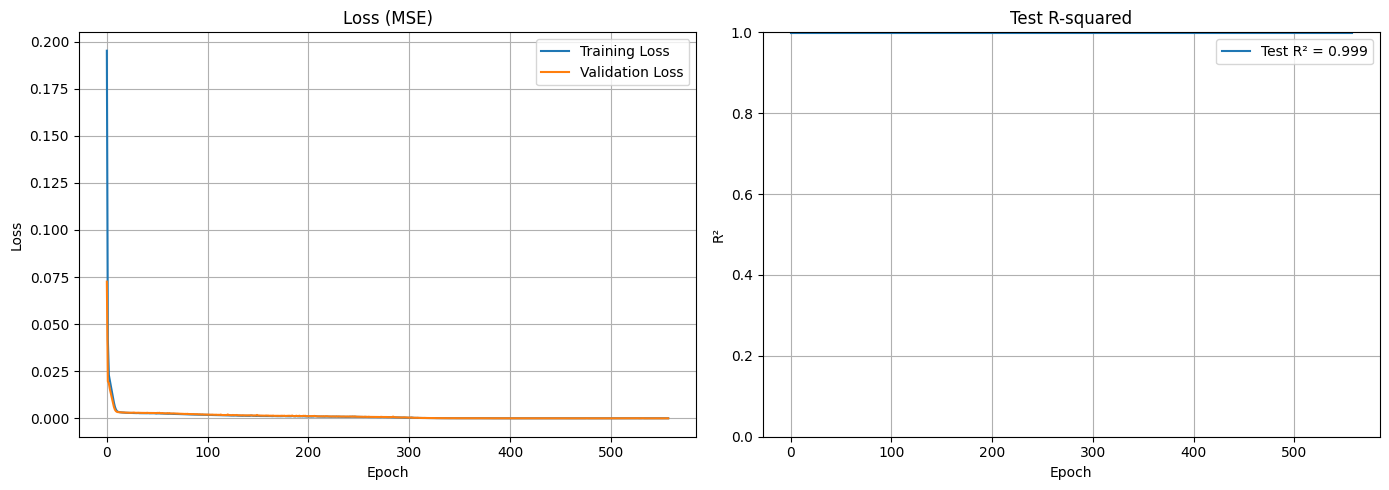

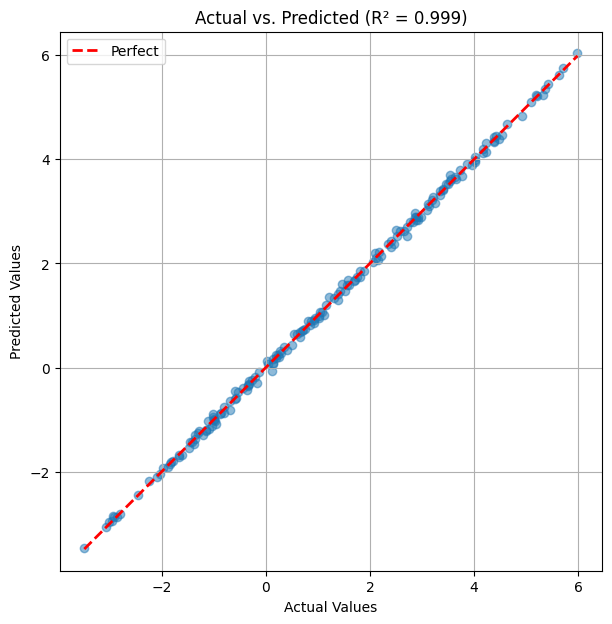

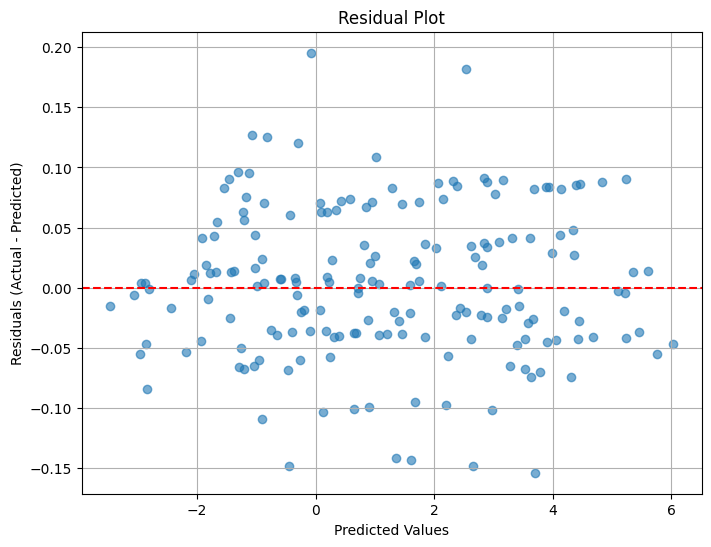


=== 최종 모델 성능 요약 ===
모델 구조: 2-32-16-1
활성화 함수: relu
테스트 R²: 0.9992
테스트 MAE: 0.0492


In [11]:
from skorch.helper import predefined_split
from skorch import dataset as dt
# 최적 파라미터로 최종 학습 (train+val 병합 or 별도 early stopping)
X_train_final = np.concatenate([X_train_scaled, X_val_scaled], axis=0)
Y_train_final = np.concatenate([Y_train_scaled, Y_val_scaled], axis=0)

ds_valid = dt.Dataset(X_val_scaled, Y_val_scaled)
final_net = NeuralNetRegressor(
    module=MLPRegressor,
    module__input_dim=nx,
    module__units1=optimal_units1,
    module__units2=optimal_units2,
    module__activation=optimal_activation,
    optimizer=Adam,
    criterion=nn.MSELoss,
    max_epochs=1000,  # 충분히 크게 두고 EarlyStopping으로 수렴 시점 선택
    batch_size=optimal_batch_size,
    lr=1e-3,
    iterator_train__shuffle=True,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    callbacks=[
        EarlyStopping(monitor='valid_loss', patience=20, load_best=True),
    ],
    train_split=predefined_split(ds_valid),
)

# skorch는 validation_split을 내부에서 처리할 수도 있고, validation 데이터를 명시할 수도 있습니다.
# 여기서는 내부 split 사용 (validation_split=0.15 등) 또는 별도로 제공하려면 train_split 매개변수로 지정.
# final_net.set_params(train_split=0.15)  # 아래에서 직접 validation_data 전달하지 않을 때 None으로 두면 전체를 훈련에 사용
history = final_net.fit(X_train_scaled, Y_train_scaled)

# 테스트 성능
from sklearn.metrics import mean_absolute_error
Y_pred_scaled = final_net.predict(X_test_scaled)

# 스케일 역변환
Y_pred = scaler_y.inverse_transform(Y_pred_scaled)
Y_test_true = y_test

# MSE/MAE/R2
test_mae = mean_absolute_error(Y_test_true, Y_pred)
r2 = r2_score(Y_test_true, Y_pred)

print("\n--- 테스트 데이터 이용 모델 성능 평가 ---")
print(f"테스트 데이터 평균 절대 오차 (MAE): {test_mae:.4f}")
print(f"테스트 데이터 결정계수 (R²): {r2:.4f}")

# skorch history 시각화 (loss만 예시)
import matplotlib.pyplot as plt
h = final_net.history
train_loss = [row['train_loss'] for row in h]
val_loss = [row.get('valid_loss', np.nan) for row in h]

fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(14,5))
ax1.plot(train_loss, label='Training Loss')
if not np.isnan(val_loss).all():
    ax1.plot(val_loss, label='Validation Loss')
ax1.set_title('Loss (MSE)')
ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)

ax3.plot([r2]*len(train_loss), label=f'Test R² = {r2:.3f}')
ax3.set_title('Test R-squared')
ax3.set_xlabel('Epoch'); ax3.set_ylabel('R²'); ax3.legend(); ax3.grid(True)
ax3.set_ylim(bottom=0, top=1)
plt.tight_layout(); plt.show()

# 실제-예측 산점도
plt.figure(figsize=(7,7))
plt.scatter(Y_test_true, Y_pred, alpha=0.5)
plt.plot([Y_test_true.min(), Y_test_true.max()], [Y_test_true.min(), Y_test_true.max()], 'r--', lw=2, label='Perfect')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs. Predicted (R² = {r2:.3f})")
plt.legend(); plt.grid(True); plt.axis('equal')
plt.show()

# 잔차 플롯
residuals = (Y_test_true.flatten() - Y_pred.flatten())
plt.figure(figsize=(8,6))
plt.scatter(Y_pred, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot')
plt.grid(True)
plt.show()

print(f"\n=== 최종 모델 성능 요약 ===")
print(f"모델 구조: {nx}-{optimal_units1}-{optimal_units2}-1")
print(f"활성화 함수: {optimal_activation}")
print(f"테스트 R²: {r2:.4f}")
print(f"테스트 MAE: {test_mae:.4f}")